# Image-Generation-Finetuning

## Install dependencies

In [1]:
import os
os.environ["HF_DATASETS_CACHE"] = "./workspace/hf_datasets"

In [1]:
!pip install -r requirements.txt

  Cloning https://github.com/LLaVA-VL/LLaVA.git to c:\users\gaizk\appdata\local\temp\pip-req-build-kjazujv9
  Resolved https://github.com/LLaVA-VL/LLaVA.git to commit 786aa6a19ea10edc6f574ad2e16276974e9aaa3a
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
INFO: pip is looking at multiple versions of llava to determine which version is compatible with other requirements. This could take a while.


  Running command git clone --filter=blob:none --quiet https://github.com/LLaVA-VL/LLaVA.git 'C:\Users\gaizk\AppData\Local\Temp\pip-req-build-kjazujv9'
ERROR: Could not find a version that satisfies the requirement torch==2.0.1 (from llava) (from versions: 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==2.0.1


In [2]:
from diffusers import StableDiffusionPipeline, DDPMScheduler
from diffusers import UNet2DConditionModel, AutoencoderKL, LMSDiscreteScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from datasets import load_dataset
from accelerate import Accelerator
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm

## Stable Diffusion model initialization from HuggingFace

In [4]:
pretrained_model = "CompVis/stable-diffusion-v1-4"
device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionPipeline.from_pretrained(pretrained_model).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

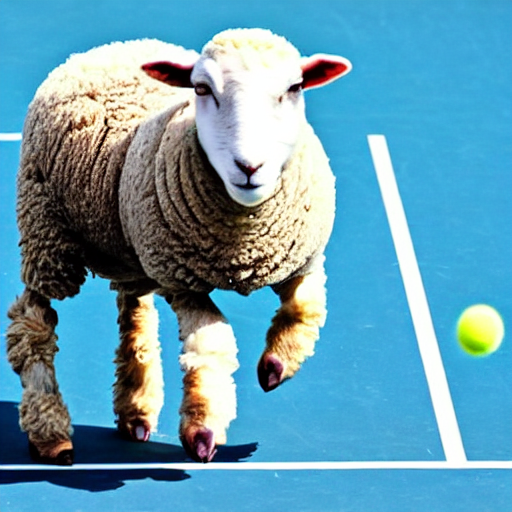

In [4]:
prompt = "an image of a sheep playing tennis with a racket"
image = pipe(prompt).images[0]

image

## Previous preparation steps

For this project we will be uploading only the training part of the images from the dataset *[oldbookillustrations](https://huggingface.co/datasets/gigant/oldbookillustrations)*. This is done to reduce training time, less memory and disk consumption and to be more manageable to experiment our finetuning.

In [5]:
train_dataset = load_dataset("gigant/oldbookillustrations", split="train[:300]")

print(train_dataset)


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00013-c0326990f575de(…):   0%|          | 0.00/628M [00:00<?, ?B/s]

data/train-00001-of-00013-a511e1086f1718(…):   0%|          | 0.00/439M [00:00<?, ?B/s]

data/train-00002-of-00013-ae73a77722dcbf(…):   0%|          | 0.00/424M [00:00<?, ?B/s]

data/train-00003-of-00013-35d02b418784cb(…):   0%|          | 0.00/363M [00:00<?, ?B/s]

data/train-00004-of-00013-0ad17a1426c919(…):   0%|          | 0.00/344M [00:00<?, ?B/s]

data/train-00005-of-00013-3cbbb7c7b88a34(…):   0%|          | 0.00/337M [00:00<?, ?B/s]

data/train-00006-of-00013-7726144afc1519(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

data/train-00007-of-00013-f77d0704c56194(…):   0%|          | 0.00/318M [00:00<?, ?B/s]

data/train-00008-of-00013-e768b38e3eb38e(…):   0%|          | 0.00/370M [00:00<?, ?B/s]

data/train-00009-of-00013-7e18348b50d9c8(…):   0%|          | 0.00/354M [00:00<?, ?B/s]

data/train-00010-of-00013-dc5f8380886ecc(…):   0%|          | 0.00/432M [00:00<?, ?B/s]

data/train-00011-of-00013-2e765ba2d2b351(…):   0%|          | 0.00/366M [00:00<?, ?B/s]

data/train-00012-of-00013-cf490ec155e3b8(…):   0%|          | 0.00/388M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4154 [00:00<?, ? examples/s]

Dataset({
    features: ['rawscan', '1600px', 'info_url', 'info_src', 'info_alt', 'artist_name', 'artist_birth_date', 'artist_death_date', 'artist_countries', 'book_title', 'book_authors', 'book_publishers', 'date_published', 'openlibrary-url', 'tags', 'illustration_source_name', 'illustration_source_url', 'illustration_subject', 'illustration_format', 'engravers', 'image_title', 'image_caption', 'image_description', 'rawscan_url', '1600px_url'],
    num_rows: 300
})


Once that part of the dataset is already downloaded in our local machine we can just execute this next cell.

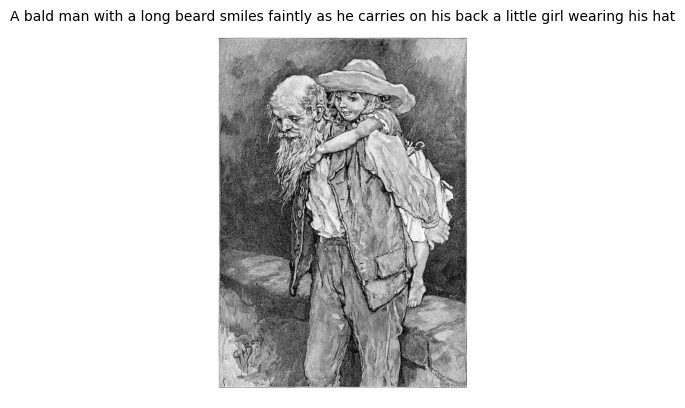

In [8]:
import matplotlib.pyplot as plt

image = train_dataset[0]["1600px"]
caption = train_dataset[0]["info_alt"]

plt.imshow(image)
plt.axis("off")
plt.title(caption, fontsize=10)
plt.show()

In [6]:
rgb = True

for img in train_dataset["1600px"]:
    if img.mode != "RGB":
        print("There are different images using a non RGB convention")
        rgb = False

if rgb:
    print("Everything following the RGB convention")

Everything following the RGB convention


When reading dataset documentation, we can see that the images are not necessarily the same size. This can be read at the feature description:

'*1600px*': the cleaned image, resized to a width of 1600 pixels (height can vary)

In [7]:
resolution = 512
image_transforms = transforms.Compose([
    transforms.Resize((resolution, resolution)),             # resizing
    transforms.CenterCrop(resolution),                       # como son de diferentes tamaños centramos las imágenes antes de recortarla
    transforms.ToTensor(),                                   # convertir a tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # normalizacion
])

An example of the transformations previously made

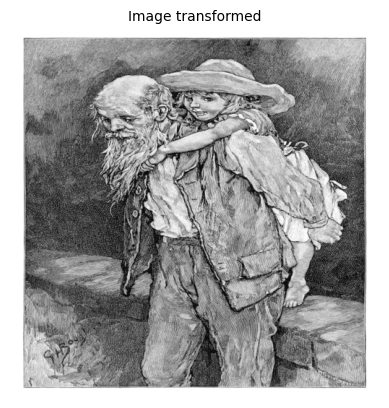

In [ ]:
original_image = train_dataset[0]["1600px"]
transformed_image = image_transforms(original_image)
# transformed_pil_image = transforms.ToPILImage()(transformed_image)

def denormalize(tensor):
    return (tensor * 0.5 + 0.5).clamp(0,1)

# la desnormalizamos porque al pasarla a pil para mostrarla intenta usar el rango 0 a 1 y no el de -1 a 1 como hemos establecido
img_show = denormalize(transformed_image).permute(1,2,0)

plt.imshow(img_show)
plt.axis("off")
plt.title("Image transformed", fontsize=10)
plt.show()

In [8]:
# Creamos un Dataset wrapper para la hora del entrenamiento:
from transformers import AutoTokenizer, AutoProcessor

processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
tokenizer = processor.tokenizer

# tokenizer = AutoTokenizer.from_pretrained("llava-hf/llava-1.5-7b-hf", subfolder="tokenizer", use_fast=False)

batch_size = 2  # no puede ser mayor por la limitacion de GPU

class Text2ImageDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = image_transforms(example["1600px"].convert("RGB"))
        token = tokenizer(example["image_description"], padding="max_length", truncation=True, max_length=tokenizer.model_max_length, return_tensors="pt")
        return {
            "pixel_values": image,
            "input_ids": token.input_ids.squeeze(0),
            "attention_mask": token.attention_mask.squeeze(0),
        }

train_dataset = Text2ImageDataset(train_dataset)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

## Model Finetuning

In [9]:
del pipe
torch.cuda.empty_cache()

In [10]:
# Tokenizador:
tokenizer = CLIPTokenizer.from_pretrained(pretrained_model, subfolder='tokenizer')

# Scheduler:
noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model, subfolder="scheduler")

# Text Encoder (CLIP):
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model,
    subfolder="text_encoder",
).to(device)

# VAE: Autoencoder:
vae = AutoencoderKL.from_pretrained(
    pretrained_model,
    subfolder="vae",
).to(device)

# La UNet:
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model,
    subfolder="unet",
).to(device)

In [11]:
vae.eval()
text_encoder.eval()

for param in vae.parameters():
    param.requires_grad = False
for param in text_encoder.parameters():
    param.requires_grad = False

In [12]:
# Optimizador:
learning_rate = 1e-5
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)

# Acelerador:
accelerator = Accelerator()
unet, optimizer, train_dataloader = accelerator.prepare(unet, optimizer, train_dataloader)
print(accelerator.device)

cuda


In [13]:
torch.cuda.empty_cache()
# Training loop:
num_epochs = 2

for epoch in range(num_epochs):
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch}")

    for batch in progress_bar:

        # Se pasan los pixeles al espacio latente con el encoder del VAE:
        with torch.no_grad():
            latents = vae.encode(batch["pixel_values"].to(accelerator.device)).latent_dist.sample()
            latents = latents * 0.18215

        # Proceso de difusion hacia delante:
        # 1. Creamos ruido aleatorio
        noise = torch.randn_like(latents)
        # 2. Cogemos un timestep aleatorio:
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (latents.shape[0],), device=latents.device).long()
        # 3. Añadimos ruido al vector del espacio latente:
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Codificamos el texto:
        encoder_hidden_states = text_encoder(batch["input_ids"].to(accelerator.device))[0]

        # Con el vector con ruido, el timestep, y el vector de texto, hacemos la prediccion de ruido:
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

        # Calculamos el error y actualizamos los parametros:
        loss = torch.nn.functional.mse_loss(noise_pred, noise)
        accelerator.backward(loss)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.set_postfix(loss=loss.item())

Epoch 1: 100%|██████████| 150/150 [01:52<00:00,  1.33it/s, loss=0.265]  


In [14]:
output_dir = "./finetuned-model"

unet.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./finetuned-model/tokenizer_config.json',
 './finetuned-model/special_tokens_map.json',
 './finetuned-model/vocab.json',
 './finetuned-model/merges.txt',
 './finetuned-model/added_tokens.json')

In [7]:
output_dir = "./finetuned-model"

finetuned_unet = UNet2DConditionModel.from_pretrained(output_dir)
finetuned_unet.to(device)

print('Modelo finetuneado cargado correctamente!')

Modelo finetuneado cargado correctamente!


In [8]:
from diffusers import StableDiffusionPipeline

# Cargamos el modelo pre-entrenado pero sustituyendo la UNet por la nuestra:
pipe = StableDiffusionPipeline.from_pretrained(
    pretrained_model,
    unet=finetuned_unet,
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

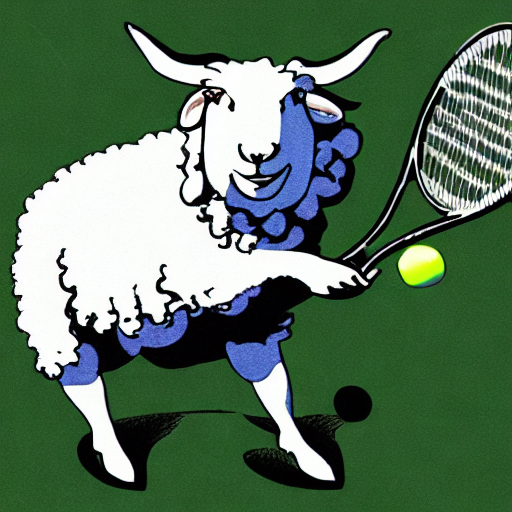

In [25]:
prompt = "an image of a sheep playing tennis with a tennis racket"
image = pipe(prompt).images[0]

image